# Bikes in Copenhagen

## Motivation

> What is your dataset?
> Why did you choose this/these particular dataset(s)?
> What was your goal for the end user's experience?

The dataset consists of the *hourly bike count* in a *13 different locations*, the data was collected between years *2005 - 2014*. The original datasets can be found in this webpage:
https://www.opendata.dk/city-of-copenhagen/faste-cykeltaellinger

As foreigners living in Denmark we were really suprised by the danish biking culture and number of bikes we saw on the streets of Copenhagen. We wanted to get better understanding of number of people using bikes, when are the bike rush hours and if data confirms our observation of Danish people biking regardless bad weather.


Our aim was to familiarise readers with Danish cycling culture and show interesting facts about cycling in Copenhagen. The article gives an insight into cycling patterns, when and where people cycle, and how the weather affects cycling.



In [1]:
# Imports
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

from plotly.subplots import make_subplots

import calendar

import numpy as np
import folium
import seaborn as sns

import matplotlib.pyplot as plt
import math

## Basic stats. 

Let's understand the dataset better.

Write about your choices in data cleaning and preprocessing
Write a short section that discusses the dataset stats, containing key points/plots from your exploratory data analysis.

> Let's understand the dataset better.


>Write about your choices in data cleaning and preprocessing
>Write a short section that discusses the dataset stats, containing key points/plots from your exploratory data analysis.



In [5]:
import requests
url = 'https://github.com/zuzell/socialdata/raw/main/Data/bicycle_traffic_fixed.pkl'
response = requests.get(url)

import pickle
df = pickle.loads(response.content)
#df = pd.read_csv('bicycle_traffic_fixed.csv')
df.tail(5)

AttributeError: Can't get attribute '_unpickle_block' on <module 'pandas._libs.internals' from '/shared-libs/python3.9/py/lib/python3.9/site-packages/pandas/_libs/internals.cpython-39-x86_64-linux-gnu.so'>

To make it easier to use the dataset in further analysis steps, we have added new columns, e.g. total and average daily traffic.

In [3]:
len(df.Dato.unique())/365

# Modify date format
df['Dato']=pd.to_datetime(df['Dato'], format='%d.%m.%Y')

# Create direction column
last_char = lambda x: x[-1]
df['Direction']=df['Vej-Id'].apply(last_char)

# Create day_of_week column
df['Day_of_Week'] = df['Dato'].dt.strftime('%A')

hours_columns=['kl.00-01', 'kl.01-02', 'kl.02-03', 'kl.03-04','kl.04-05','kl.05-06','kl.06-07','kl.07-08','kl.08-09','kl.09-10',
               'kl.10-11','kl.11-12', 'kl.12-13', 'kl.13-14','kl.14-15','kl.15-16','kl.16-17','kl.17-18','kl.18-19','kl.19-20',
               'kl.20-21','kl.21-22', 'kl.22-23','kl.23-24']

df['Traffic_sum']= df[hours_columns].sum(axis=1)
df['Traffic_hourly_average']= df[hours_columns].mean(axis=1)
df['Year']=df['Dato'].dt.year
df['Month']=df['Dato'].dt.month

# Create total count of day
hours = ['00','01','02','03','04','05','06','07','08','09','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24']
df['Count'] = 0
for h in range(0, len(hours)-1):
    df['Count'] = df['Count'] + df['kl.'+hours[h]+'-'+hours[h+1]]

# Visualise modified dataset
df.head()

,Unnamed: 0,Vej-Id,Vejnavn,Spor,(UTM32),(UTM32).1,Dato,kl.00-01,kl.01-02,kl.02-03,...,kl.22-23,kl.23-24,Location,Direction,Day_of_Week,Traffic_sum,Traffic_hourly_average,Year,Month,Count
0,0,101 1011600-0 2/ 400 -,Englandsvej,NaN,726552,6171708,2005-01-01,0.0,0.0,0.0,...,0.0,0.0,"[55.63834706500187, 12.599838269435882]",-,Saturday,0.0,0.0,2005,1,0.0
1,1,101 1011600-0 2/ 400 -,Englandsvej,NaN,726552,6171708,2005-01-02,0.0,0.0,0.0,...,0.0,0.0,"[55.63834706500187, 12.599838269435882]",-,Sunday,0.0,0.0,2005,1,0.0
2,2,101 1011600-0 2/ 400 -,Englandsvej,NaN,726552,6171708,2005-01-03,0.0,0.0,0.0,...,0.0,0.0,"[55.63834706500187, 12.599838269435882]",-,Monday,0.0,0.0,2005,1,0.0
3,3,101 1011600-0 2/ 400 -,Englandsvej,NaN,726552,6171708,2005-01-04,0.0,0.0,0.0,...,0.0,0.0,"[55.63834706500187, 12.599838269435882]",-,Tuesday,0.0,0.0,2005,1,0.0
4,4,101 1011600-0 2/ 400 -,Englandsvej,NaN,726552,6171708,2005-01-05,0.0,0.0,0.0,...,0.0,0.0,"[55.63834706500187, 12.599838269435882]",-,Wednesday,0.0,0.0,2005,1,0.0


In [4]:
hours_stats=df[hours_columns].describe()
hours_stats

,kl.00-01,kl.01-02,kl.02-03,kl.03-04,kl.04-05,kl.05-06,kl.06-07,kl.07-08,kl.08-09,kl.09-10,...,kl.14-15,kl.15-16,kl.16-17,kl.17-18,kl.18-19,kl.19-20,kl.20-21,kl.21-22,kl.22-23,kl.23-24
count,91991.000000,91759.000000,91771.000000,91992.000000,91994.000000,91995.000000,92002.000000,92002.000000,92004.000000,92013.000000,...,92024.000000,92023.000000,92018.000000,92018.000000,92019.000000,92009.000000,92005.000000,92005.000000,92002.000000,91955.000000
mean,55.390690,36.846151,28.598054,23.102194,21.360589,31.371259,93.353362,258.150018,366.893787,212.451447,...,253.945829,341.256219,388.131681,321.594590,236.649322,166.573183,126.597424,112.604706,101.158920,83.201860
std,85.778325,65.309115,57.150209,48.389364,40.941593,42.826658,121.789284,341.244759,551.930751,294.487228,...,287.382418,399.671234,486.480130,407.556945,302.136419,218.200958,165.675154,145.580525,131.407919,109.401178
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.000000,3.000000,2.000000,2.000000,3.000000,8.000000,22.000000,38.000000,47.000000,46.000000,...,72.000000,90.000000,91.000000,73.000000,51.000000,33.000000,24.000000,20.000000,18.000000,14.000000
50%,20.000000,11.000000,8.000000,7.000000,8.000000,17.000000,57.000000,140.000000,169.000000,108.000000,...,143.000000,200.000000,222.000000,176.000000,118.000000,78.000000,58.000000,50.000000,45.000000,36.000000
75%,69.000000,39.000000,26.000000,19.000000,21.000000,39.000000,112.000000,316.000000,423.000000,251.000000,...,332.000000,435.000000,477.000000,402.000000,308.000000,221.000000,171.000000,154.000000,141.000000,116.000000
max,1747.000000,1074.000000,1386.000000,2217.000000,2517.000000,2544.000000,2131.000000,3541.000000,4736.000000,4421.000000,...,3841.000000,3245.000000,4218.000000,3562.000000,2455.000000,2894.000000,2304.000000,1429.000000,4604.000000,1499.000000


We noticed that some locations were missing data for some of the days. For some plots it was necessary to create new lines with for missing days. 

In [6]:
### Alejandra
## This cells takes 6 min to run

# How many days we dont have data
total_days = 365*10 + 2
print('We dont have data for', total_days - len(df.Dato.unique()), 'days')


# Let's include the days without data in our dataframe (it takes around 6 min)
df_alldays = df
for date in pd.date_range(start='2005-01-01', end='2014-12-31'):
    date = pd.to_datetime(date, format='%d.%m.%Y')
    if date in list(df['Dato']):
        pass
    else:
        #print(date)
        # Create a new row
        new_row = {'Vej-Id': np.nan, 'Vejnavn': np.nan, 'Spor': np.nan, '(UTM32).1': np.nan, 'Dato': date, 
                   'kl.00-01': np.nan, 'kl.01-02': np.nan, 'kl.02-03': np.nan, 'kl.03-04': np.nan, 'kl.04-05': np.nan,
                   'kl.05-06': np.nan, 'kl.06-07': np.nan, 'kl.07-08': np.nan, 'kl.08-09': np.nan, 'kl.09-10': np.nan, 
                   'kl.10-11': np.nan, 'kl.11-12': np.nan, 'kl.12-13': np.nan, 'kl.13-14': np.nan, 'kl.14-15': np.nan,
                   'kl.15-16': np.nan, 'kl.16-17': np.nan, 'kl.17-18': np.nan, 'kl.18-19': np.nan, 'kl.19-20': np.nan,
                   'kl.20-21': np.nan, 'kl.21-22': np.nan, 'kl.22-23': np.nan, 'kl.23-24': np.nan,
                   'Location': np.nan, 'Direction': np.nan, 'Day_Of_Week': np.nan, 'Count': 0.0}

        # Add the new row to the DataFrame
        df_alldays = df_alldays.append(new_row, ignore_index=True)

We dont have data for 70 days


## Data Analysis

>Describe your data analysis and explain what you've learned about the dataset.
>If relevant, talk about your machine-learning.

In this step we created a few simple plots to search for some interesting trends in the data. We plotted map with locations, monthly average and mean hourly bike counts

In [7]:
m1 = folium.Map([ 55.676098, 12.568337],tiles="Stamen Toner", zoom_start=14)


def plotDot(point, color, radius, vejnavn):
    folium.CircleMarker(location=point,
                        radius=radius,
                        weight=5,
                        color=color,
                        popup=f"<i>{vejnavn}</i>"
                        ).add_to(m1)

# Group the DataFrame by 'Vejnavn' and add a new column with a unique identifier for each location within each group
df['Location ID'] = df.groupby('Vejnavn').ngroup()

# Iterate through the unique locations
for location_id in df['Location ID'].unique():
    subset = df.loc[df['Location ID'] == location_id]
    location=subset['Location'].iloc[0]
    plotDot(location, '#ff7f0e', 3,subset['Vejnavn'].iloc[0] )


#m1.save("map.html")
m1

ValueError: Expected two (lat, lon) values for location, instead got: '[55.63834706500187, 12.599838269435882]'.

Mean bike count by hour

<AxesSubplot: >

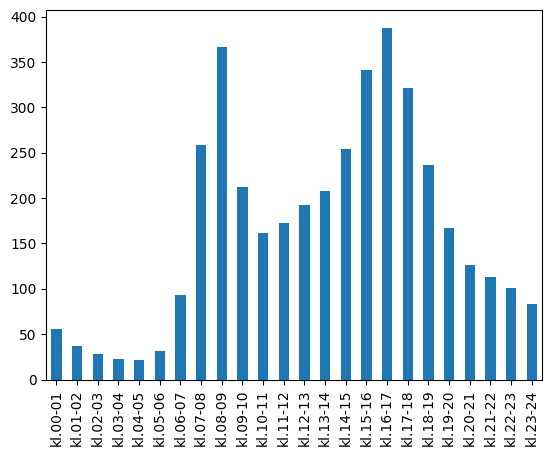

In [5]:
hours_stats.loc['mean'].plot(kind='bar')

Here we noticed that there were two noticeable peaks in bicycle traffic. 

We wanted to check how the bike count changes over the year.

In [0]:
data=df[['Month','Vejnavn', 'Direction','Traffic_sum', 'Dato']]
data=data[data['Direction']=='+']


# Group the DataFrame by 'Vejnavn' and 'Direction', and sum the hourly columns
grouped_df = data.groupby(['Month'])[['Traffic_sum']].mean()

# Iterate over the unique 'Vejnavn' values and create a bar plot for each

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8,5))
#flatten for easier indexing

fig.suptitle('Average count of bikes by month',fontsize =20)



# Create a new figure and plot the group as a bar plot
ax = axes
grouped_df.plot(kind='bar', ax=ax,color ='#F7E1FF', edgecolor ='#BE98CB', linewidth = 2,width = 0.5, legend=False)

# Set the title and axis labels
ax.set_title(f'Mean daily bike counts by Month')
ax.set_xlabel('Month')
ax.set_ylabel('Daily average')

ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

# Show the plot
plt.tight_layout()
plt.show()

As we expect the change to be strongly correlated with the weather, we extended our analysis in a further analysis.

### Machine learning - Trying to predict bike counts by temperature

We had data for the temperature for every day from 2005 to 2014 and also the bike counts. Based on this data, we wanted to build a Machine learning model to predict the bike counts based on the single variable of temperature. We show the results in the following cells.

In [4]:
weather = pd.read_csv('https://raw.githubusercontent.com/zuzell/socialdata/main/Data/climate_CPH.csv')
 
# Modify date format
weather['Dato']=pd.to_datetime(weather['date_mine'], format='%Y.%m.%d')

# Select from 2005 to 2014
weather = weather[weather['Year'] >= 2005]
weather = weather[weather['Year'] <= 2014]

# create dataframe
gg = df_alldays.groupby(['Dato']).sum()

## Merge both
weather['Count'] = list(gg['Count'])
weather

NameError: name 'df_alldays' is not defined

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

# Prepare dataset
weather = weather[['Count','Dato','Year', 'AvgTemperature']]
# Drop rows with any NaN values
weather.dropna(inplace=True)

# Separate input features (X) and target variable (y)
x = list(weather['AvgTemperature'])
X = np.column_stack((np.ones(len(x)), x)) # [1, x]
y = list(weather['Count'])
N = len(weather)

# Split the data into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a linear regression model and fit it to the training data
model = LinearRegression()
model.fit(X_train, y_train)

# Create a ridge regression model and fit it to the training data
model_ridge = Ridge(alpha=1.0)
model_ridge.fit(X_train, y_train)

# Use the trained model to make predictions on the test data
y_pred = model.predict(X_test)
y_pred_ridge = model_ridge.predict(X_test)


# Evaluate the performance of the model
score = model.score(X_test, y_test)
print(f'R-squared score for linear model: {score:.2f}')
score_ridge = model_ridge.score(X_test, y_test)
print(f'R-squared score for ridge regression model: {score_ridge:.2f}')

We see that the R-squared scores for both models are very low (close to zero), so that we cannot properly predict the bike counts just based on the temperature with these models. For a more detailed examination, we would need to inspect more models or use more variables to predict the bike counts.

## Genre. 

Which genre of data story did you use?
Which tools did you use from each of the 3 categories of Visual Narrative (Figure 7 in Segal and Heer). Why?
Which tools did you use from each of the 3 categories of Narrative Structure (Figure 7 in Segal and Heer). Why?

In our project we decided to use Magazine-style data presentation because we believe it is  the ideal option for a story that calls for an absorbing and eye-catching format to provide information. It enables the addition of different design components like pictures, infographics, charts, and other visual aids that can increase the data's accessibility  to a wider audience. 

With regard to the Visual Narrative tools, we make use of the Consistent Visual Platform, which ensures by consistent layout of our page, that the information on it is presented to the user in an orderly and understandable way. We also use highlighting (size of fonts, headings, boldness) to draw the viewer's attention to the most important information in a given paragraph.

As far as Narrative Structure is concerned, our page begins with an Introductory Text which is intended to outline the phenomenon under investigation for the user. Our story is told in a linear fashion, starting with an outline of the broader context and comparisons with other cities around the world, and concluding with detailed background data. All of our graphs and charts utilize multi-messaging, giving unique but connected data. Some of the graphs are also highly interactive, allowing the user to select, for example, the street or year for which they want to examine the data. In addition, details of a particular chart are also available by hovering over the relevant datapoint. We believe that such interaction on the user's part has a positive effect on his/her absorption of information.

## Visualizations.

>Explain the visualizations you've chosen.
>Why are they right for the story you want to tell?

### Bicycle usage in Europe

This plot shows the proportion of bicycle use as a percentage of total number of trips in several countries in Europe.

In [0]:
#Bicycle Share of Trips in Europe (percent of total trips by bicycle)

countries = ['UK', 'France', 'Norway', 'Austria', 'Switzerland', 'Belgium', 'Germany', 'Sweden', 'Finland', 'Denmark', 'Netherlands']
percentages = [2, 3, 4, 5, 6, 8, 9, 10, 11, 18, 27]

import plotly.graph_objects as go

# Define a list of colors for the bars
colors = ['#7979fc']*len(countries)
colors[-2] = '#ef553c'

fig = go.Figure(go.Bar(x=percentages, y=countries, orientation='h', marker=dict(color=colors)))

# Details of plot
annotations = []
for xd, yd in zip(countries, percentages):
    annotations.append(dict(xref='x1', yref='y1',
                            y=xd, x=yd + 2,
                            text=str(yd) + '%',
                            font=dict(family='Verdana', size=12,
                                      color='black'),
                            showarrow=False))
# Source
annotations.append(dict(xref='paper', yref='paper',
                        x=0.5, y=-0.15,
                        text='Proportion of bicycle use as a percentage of total number of trips in several countries of Europe. Buehler and Pucher, 2012.',
                        font=dict(family='Verdana', size=12, color='black'),
                        showarrow=False))
fig.update_layout(annotations=annotations, 
                  paper_bgcolor='rgb(243, 243, 243)', 
                  plot_bgcolor='rgb(243, 243, 243)',
                  title='Bycicle usage in Europe')

fig.show()

# save the plot as an HTML file
#fig.write_html('bike-use-europe.html', include_plotlyjs='cdn')

### Mean daily bike count by month

In [0]:

colors = px.colors.qualitative.Plotly

#Take only + direction
filtered_df = df[df['Direction'] == '+']

# Create a list of unique street names
streets = filtered_df['Vejnavn'].unique()

fig = go.Figure()

# Loop over the list of streets and add a trace for each one
for i, street in enumerate(streets):

    street_df=filtered_df[filtered_df['Vejnavn']==street]
    #print(len(street_df))
    # Group the data by year and month and calculate the mean traffic sum
    grouped_df = street_df.groupby(['Month'])['Traffic_sum'].mean().reset_index()
    
    # Add a trace for the street to the figure
    fig.add_trace(
        go.Bar(
            x=grouped_df['Month'],
            y=grouped_df['Traffic_sum'],
            name=street,
            visible=True,
            marker_color=colors[1] #[i % len(colors)]  # Wrap around to beginning of color list if i is too large
        )
    )


month_names = [calendar.month_name[i] for i in range(1, 13)]
fig.update_layout(xaxis=dict(tickvals=list(range(1, 13)), ticktext=month_names))


# Make it interactive with dropdown menu
Ld=len(fig.data)
for k in range(1, Ld):
    fig.update_traces(visible=False, selector = k)
    
buttons = []

for i, year in enumerate(streets):
    args = [False] * len(streets)
    args[i] = True
    
    button = dict(label = year,
                  method = "update",
                  args=[{"visible": args}])
    
    buttons.append(button)
    
fig.update_layout(
    updatemenus=[dict(
                    active=0,
                    type="dropdown",
                    buttons=buttons,
                    x = 1.15,
                    y = 1,
                    xanchor = 'right',
                    yanchor = 'bottom'
                )], 
    autosize=True,
    #width=500, 
    #height=400
)

# Customize
fig.update_layout(title_text=f'Mean daily bike count by month',
                  title_font_size=20,
                  paper_bgcolor='rgb(243, 243, 243)',
                  plot_bgcolor='rgb(243, 243, 243)',
                  xaxis_title_text='Months',
                  yaxis_title_text='Bike count')
fig.show()
fig.write_html("Bike_counts_month_2.html",include_plotlyjs='cdn')

### Weather data

Plot of the average temperature and precipitation in Copenhagen from 1991 to 2020. The data was taken from https://climateknowledgeportal.worldbank.org/

Plotting the average temperatures and rainfall gives better understanding of how weather changes over the year and how it affects the bicycle traffic

In [3]:
mean_temp_data = pd.read_csv('https://raw.githubusercontent.com/zuzell/socialdata/main/Data/tas_climatology_annual-monthly_cru_1991-2020_DNK.csv', skiprows = 1)
mean_precip_data = pd.read_csv('https://raw.githubusercontent.com/zuzell/socialdata/main/Data/pr_climatology_annual-monthly_cru_1991-2020_DNK.csv',skiprows = 1)
min_temp_data = pd.read_csv('https://raw.githubusercontent.com/zuzell/socialdata/main/Data/tasmin_climatology_annual-monthly_cru_1991-2020_DNK.csv', skiprows = 1)
max_temp_data = pd.read_csv('https://raw.githubusercontent.com/zuzell/socialdata/main/Data/tasmax_climatology_annual-monthly_cru_1991-2020_DNK.csv', skiprows = 1)

mean_temp_data=mean_temp_data.set_index(mean_temp_data.columns[0])
mean_precip_data=mean_precip_data.set_index(mean_precip_data.columns[0])
min_temp_data=min_temp_data.set_index(min_temp_data.columns[0])
max_temp_data=max_temp_data.set_index(max_temp_data.columns[0])

mean_temp_data=mean_temp_data.drop(columns='Annual')
mean_precip_data=mean_precip_data.drop(columns='Annual')
min_temp_data=min_temp_data.drop(columns='Annual')
max_temp_data=max_temp_data.drop(columns='Annual')

mean_temp_data=mean_temp_data[mean_temp_data.index=='Koebenhavn']
mean_precip_data=mean_precip_data[mean_precip_data.index=='Koebenhavn']
min_temp_data=min_temp_data[min_temp_data.index=='Koebenhavn']
max_temp_data=max_temp_data[max_temp_data.index=='Koebenhavn']

In [0]:
# Creating a DataFrame with the data

avg_temp=mean_temp_data.values.flatten().tolist()
precipitation=mean_precip_data.values.flatten().tolist()
min_temp=min_temp_data.values.flatten().tolist()
max_temp=max_temp_data.values.flatten().tolist()


df = pd.DataFrame({'Month': ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
                   'Average Temperature': avg_temp,
                   'Precipitation': precipitation,
                   'Min Temperature': min_temp,
                   'Max Temperature': max_temp})


fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Bar(x=df['Month'], y=[max_val - min_val for max_val, min_val in zip(max_temp, min_temp)], 
           name='Avg Temp', base=min_temp, marker=dict(color='orange', line=dict(width=2))), 
    secondary_y=False,
)

fig.add_trace(
    go.Bar(x=df['Month'], y=df['Precipitation'], name='Precipitation', marker=dict(color='blue'), opacity=0.5),
    secondary_y=True,
)

fig.update_layout(
    title_text='Average Temperature and Precipitation by Month',
    title_font_size=20,
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)',
    xaxis=dict(title='Month')
)


fig.update_yaxes(title_text="Average Temperature (°C)", secondary_y=False)
fig.update_yaxes(title_text="Precipitation (mm)", secondary_y=True)


fig.show()
#fig.write_html("Average_temp_maxmin.html", include_plotlyjs='cdn')

Daily weather plots

Plots with average weather conditions, only gave us information that temperature trends match the bike count over the year. Although to proof that the correlation exist, we performed more in depth analysis on daily temperature and bicycle traffic.

Plot for temperature and bike counts from 2005 to 2014

In [0]:
## Alejandra

climate = pd.read_csv('https://raw.githubusercontent.com/zuzell/socialdata/main/Data/climate_CPH.csv')
 
# Modify date format
climate['Dato']=pd.to_datetime(climate['date_mine'], format='%Y.%m.%d')

# Select from 2005 to 2014
climate = climate[climate['Year'] >= 2005]
climate = climate[climate['Year'] <= 2014]

# create dataframe
gg = df_alldays.groupby(['Dato']).sum()

## Merge both
climate['Count'] = list(gg['Count'])

## Plot
sns.set_style('darkgrid')
sns.set(font_scale=1.5)

y = climate['Count']
x = climate['AvgTemperature']
xticks = [str(i)[:10] for i in climate['Dato']]
xticks = climate['Year']

y = (y - np.mean(y))/np.std(y)
x = (x - np.mean(x))/np.std(x)
N = len(y)

f, ax = plt.subplots(figsize=(15, 5))
plt.plot(range(N), x, '-', color='#3e059b', label='AvgTemperature', alpha=0.8)
plt.plot(range(N), y, color='#f3894a', label='Bike counts', alpha=0.8)
# Set the x-tick values
plt.xticks(range(0,N,365), xticks[0:N:365], rotation=45)
plt.legend()

Plots for the year 2007 - correlation between bike traffic and weather

The dataset was found on the webpage: https://www.visualcrossing.com/

In [2]:
weather_2007=pd.read_csv('https://raw.githubusercontent.com/zuzell/socialdata/main/Data/copenhagen%202007-01-01%20to%202007-12-31.csv')

df_weather=weather_2007[['datetime', 'tempmax', 'tempmin', 'temp', 'feelslikemax',
       'feelslikemin', 'feelslike','precip', 'precipprob',
       'precipcover', 'preciptype', 'snow', 'snowdepth',]]

df_weather['datetime']=pd.to_datetime(df_weather['datetime'], format='%Y-%m-%d')

/tmp/ipykernel_87/2808886303.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weather['datetime']=pd.to_datetime(df_weather['datetime'], format='%Y-%m-%d')


In [0]:
## Alejandra

## Correlation matrix
df_weather_corr = df_weather[['datetime','temp', 'precip']]

# Create count in 2007
count_per_day = df_alldays.groupby(['Dato']).sum()
count_2007 = count_per_day[count_per_day.index.year == 2007]

# merge both
df_2007 = df_weather_corr
df_2007['Count'] = list(count_2007['Count'])

## Correlation
f, ax = plt.subplots(figsize=(8, 5))

# set the background color of the figure
f.set_facecolor('#f3f3f3')
sns.heatmap(df_2007.corr(), annot=True, cmap="plasma")

plt.title('Correlation matrix', size=15, color='#2b3f5f')
ax.set_xticklabels(list(df_2007.columns), size=12, rotation=90, color='#2b3f5f')
ax.set_yticklabels(list(df_2007.columns), size=12, rotation=0, color='#2b3f5f')

In [0]:
data=df[['Traffic_sum','Vejnavn', 'Direction', 'Dato']]
data=data[data['Dato'].dt.year == 2007]
data = data[data['Vejnavn'] == 'Tuborgvej']
data = data[data['Direction'] == 'T']
grouped_df = data.groupby(['Dato'])[['Traffic_sum']].sum().reset_index()

merged_df = pd.merge(grouped_df, df_weather, left_on='Dato', right_on='datetime')
merged_df['precip_size']=merged_df.apply(lambda x: float(x['precip']) + 5.0, axis =1)
merged_df

In [0]:
fig = px.scatter(merged_df, x="temp", y="Traffic_sum", size="precip_size", color="precip")

fig.update_layout(
    title="Traffic vs Temperature in 2007 on Tuborgvej'",
    xaxis_title="Average temperature (°C)",
    yaxis_title="Bike Traffic",
    title_font_size=20,
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)',
    showlegend=False,
    hovermode="closest",
    font=dict(size=12)
)

fig.show()
fig.write_html("Bubble_plot_temp.html", include_plotlyjs='cdn')

The plots presented above, proof our hypothesis that temperature affects the use of bikes in copenhagen.

### Cycling purpose

Plot of average count of bikes by Weekday or Weekend in Copenhagen

In [0]:
# Add a new column to your DataFrame to differentiate between weekdays and weekends
df['Weekday_or_Weekend'] = df['Day_of_Week'].apply(lambda x: 'Weekend' if x in ['Saturday', 'Sunday'] else 'Weekday')

# Group the DataFrame by 'Vejnavn', 'Direction', and 'Weekday_or_Weekend', and compute the mean traffic count
grouped_df = df.groupby(['Vejnavn', 'Direction', 'Weekday_or_Weekend'])['Traffic_sum'].mean().reset_index()

# Create a bar plot for each unique 'Vejnavn'
fig = go.Figure()

for vejnavn in df['Vejnavn'].unique():
    group = grouped_df[grouped_df['Vejnavn'] == vejnavn]
    
    fig.add_trace(
        go.Bar(
            x=group['Weekday_or_Weekend'],
            y=group['Traffic_sum'],
            name=vejnavn,
            visible=(vejnavn == df['Vejnavn'].unique()[0]),
            marker=dict(color='orange')
        )
    )

# Create a dropdown menu with all unique street names
street_names = df['Vejnavn'].unique()

buttons = []

for i, street in enumerate(street_names):
    visible_traces = [False] * len(street_names)
    visible_traces[i] = True
    
    button = dict(
        label=street,
        method="update",
        args=[{"visible": visible_traces}]
    )
    
    buttons.append(button)

fig.update_layout(
    updatemenus=[
        dict(
            active=0,
            type="dropdown",
            buttons=buttons,
            x=1.15,
            y=1,
            xanchor='right',
            yanchor='bottom'
        )
    ],
    autosize=True
)

# Customize
fig.update_layout(title_text=f'Average count of bikes by Weekday vs Weekend',
                  title_font_size=20,
                  paper_bgcolor='rgb(243, 243, 243)',
                  plot_bgcolor='rgb(243, 243, 243)',
                  
                  yaxis_title_text='Daily average')
fig.show()


Hourly plot of count of bikes for each street.

In [0]:
# Define the hour columns and labels
hour_columns = [f'kl.{str(i).zfill(2)}-{str(i+1).zfill(2)}' for i in range(24)]
hour_labels = [f'{i % 12 if i % 12 != 0 else 12}{"am" if i < 12 else "pm"}-{(i+1) % 12 if (i+1) % 12 != 0 else 12}{"am" if (i+1) < 12 else "pm"}' for i in range(24)]

# Group the DataFrame by 'Vejnavn' and compute the mean traffic count for each hour
grouped_df = df.groupby('Vejnavn')[hour_columns].mean()

# Create a plot for each unique 'Vejnavn'
fig = go.Figure()

#remove the brackets to make the plot more readable
for vejnavn in df['Vejnavn'].unique():
    group = grouped_df.loc[vejnavn]
    name = vejnavn.replace(' ( ml. Nørrebrogade og Frederiksborggade)', '')
    fig.add_trace(go.Bar(x=hour_labels, y=group, name=name))

# Set the plot title and axis labels
fig.update_layout(title_text="Average hourly traffic count by Street", title_x=0.5)
fig.update_xaxes(title_text="Hour")
fig.update_yaxes(title_text="Hourly average")

# Create a dropdown menu for selecting the street
buttons = []

# Add "Show All" option to the dropdown menu
buttons.append(
    dict(
        label="Show All",
        method="update",
        args=[{"visible": [True] * len(df['Vejnavn'].unique())}]
    )
)

for i, vejnavn in enumerate(df['Vejnavn'].unique()):
    visible_list = [False] * len(df['Vejnavn'].unique())
    visible_list[i] = True

    name = vejnavn.replace(' ( ml. Nørrebrogade og Frederiksborggade)', '')
    button = dict(
        label=name,
        method="update",
        args=[{"visible": visible_list}]
    )
    buttons.append(button)

# Add the dropdown menu to the plot
fig.update_layout(
    updatemenus=[
        dict(
            type="dropdown",
            showactive=True,
            buttons=buttons,
            x=1.15,
            y=1,
            xanchor='right',
            yanchor='bottom'
        )
    ],
    autosize=True
)

# Show all streets by default
for trace in fig.data:
    trace.visible = True

# Show the plot
fig.show()

### Bicycle traffic

Plot of traffic levels in different parts of Copenhagen 

In [0]:
# First, convert the 'Location' column back to two separate columns for latitude and longitude
df[['Latitude', 'Longitude']] = pd.DataFrame(df['Location'].to_list(), index=df.index)

# Then, group by 'Latitude', 'Longitude', and 'Year' and calculate the average of 'Traffic_sum'
grouped_df = df.groupby(['Latitude', 'Longitude', 'Year'])['Traffic_sum'].mean().reset_index()

# Create the map
fig = px.scatter_mapbox(grouped_df, lat='Latitude', lon='Longitude',
                     size='Traffic_sum',
                     animation_frame='Year', 
                     color_continuous_scale=px.colors.sequential.Plasma,
                     size_max=50,
                     title = 'Bicycle Traffic in Copenhagen',
                     mapbox_style="carto-positron")

#set up the default zoom on the map to show only copenhagen area                     
fig.update_layout(mapbox=dict(center=dict(lat=55.676098, lon=12.568337), zoom=10))
# Add the slider
fig.update_layout(
    updatemenus=[
        dict(
            buttons=list([
                dict(
                    args=[None, {"frame": {"duration": 500, "redraw": True}}],
                    label="Play",
                    method="animate"
                ),
                dict(
                    args=[[None], {"frame": {"duration": 0, "redraw": True}, "fromcurrent": True, "transition": {"duration": 0}}],
                    label="Pause",
                    method="animate"
                )
            ]),
            direction="left",
            pad={"r": 10, "t": 87},
            showactive=False,
            type="buttons",
            x=0.1,
            xanchor="right",
            y=0,
            yanchor="top"
        )
    ]
)

fig.show()

### Calendar plots

First, a visualisation of all the 13 places of Copenhagen from which we have data.

In [0]:
#!pip install plotly_calplot
from plotly_calplot import calplot

# create dataframe
gg = df_alldays.groupby(['Dato']).sum()
count = gg['Count']
count = pd.DataFrame(count)
count['Dato'] = count.index
count.index.names = ['index']

# creating the plot
fig = calplot(count, x='Dato', y='Count', title = "Every place - every year", 
              dark_theme=False, showscale=True, gap=1, colorscale="purples",  # cmap_max=37000.0
              years_title=True, years_as_columns=False, #name="Data", 
              month_lines_width=2, month_lines_color="#fff",
              space_between_plots=0.04)
fig.show()

In [0]:
# Places (streets) that we can investigate
set(df_alldays['Vejnavn'])

To explore each of the places separately, just change the name of the street in the next cell.

In [0]:
# Name of the street
street = 'Ellebjergvej'

# create dataframe
df_location = df_alldays[df_alldays.Vejnavn == street]
gg = df_location.groupby(['Dato']).sum()
count = gg['Count']
count = pd.DataFrame(count)
count['Dato'] = count.index
count.index.names = ['index']

# creating the plot
fig = calplot(count, x='Dato', y='Count', title = street, 
              dark_theme=False, showscale=True, gap=1, colorscale="purples",  # cmap_max=37000.0
              years_title=True, years_as_columns=False, #name="Data", 
              month_lines_width=2, month_lines_color="#fff",
              space_between_plots=0.04)
fig.show()

# save the plot as an HTML file
#fig.write_html('calplot_'+street+'.html', include_plotlyjs='cdn')

## Discussion.

Think critically about your creation. What went well? What is still missing? What could be improved? Why?


With the limited dataset that we found and analysed, we have still been able to get curious and important insights of the habits of biking in Copenhagen. 

However, we run into some problems when analysing the dataset. There were many days in the data set that didn't contain any data and we don't know if it is because there were no bike counts that day, or because of some problems collecting the data (it is not specified in the dataset). So, in order to compare between years, some times we could not compare directly the counts. Also, for the calendar plots, we had to add the dates that were not containing any counts (with count=0.0).

Another issue with the dataset is that, even though we had the direction for the bike counts (indicated in the dataset as '+' or '-'), we couldn't really work with them because the sum of both directions was not equal to the total count (so we guessed that the data was not accurate). We solved it by just taking into account the total number of bike counts.

One thing that we could have done better is the machine learning regression model to predict the count of bikes based on other variables. We did try two very basic models (linear regression and ridge regression) with just one independent variable (temperature). The models have not showed very good accuracy (maybe because of the model themselves), but it could also be because of the fact that we used one single variable (temperature). Also, as we saw in the correlation matrix, temperature was correlated with bike counts but the correlation was not extremely high (0.33).

## Contributions. 

Who did what?
You should write (just briefly) which group member was the main responsible for which elements of the assignment. (I want you guys to understand every part of the assignment, but usually there is someone who took lead role on certain portions of the work. That's what you should explain).
It is not OK simply to write "All group members contributed equally".
Make sure that you use references when they're needed and follow academic standards.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=0bd28265-4ef9-4244-9130-dfeb6e6916c5' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>